<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Part-I:-Basics" data-toc-modified-id="Part-I:-Basics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Part I: Basics</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Imports-and-data-structures" data-toc-modified-id="Imports-and-data-structures-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports and data structures</a></span></li><li><span><a href="#Construction-of-probability-trees-using-factory-functions" data-toc-modified-id="Construction-of-probability-trees-using-factory-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Construction of probability trees using factory functions</a></span></li></ul></li><li><span><a href="#Firing-squad-(deterministic)" data-toc-modified-id="Firing-squad-(deterministic)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Firing squad (deterministic)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Misspecified-Firing-squad-story" data-toc-modified-id="Misspecified-Firing-squad-story-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Misspecified Firing squad story</a></span></li><li><span><a href="#Firing-squad-story-with-A-defined-first" data-toc-modified-id="Firing-squad-story-with-A-defined-first-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Firing squad story with A defined first</a></span></li><li><span><a href="#Firing-squad-story-with-B-defined-first" data-toc-modified-id="Firing-squad-story-with-B-defined-first-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Firing squad story with B defined first</a></span></li></ul></li><li><span><a href="#S1:-Prediction" data-toc-modified-id="S1:-Prediction-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>S1: Prediction</a></span></li><li><span><a href="#S2-Abduction" data-toc-modified-id="S2-Abduction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>S2 Abduction</a></span></li><li><span><a href="#S3-Transduction" data-toc-modified-id="S3-Transduction-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>S3 Transduction</a></span></li><li><span><a href="#S4-Action" data-toc-modified-id="S4-Action-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>S4 Action</a></span></li><li><span><a href="#S5-Counterfactual" data-toc-modified-id="S5-Counterfactual-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>S5 Counterfactual</a></span></li></ul></li><li><span><a href="#Nervous-Firing-squad" data-toc-modified-id="Nervous-Firing-squad-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Nervous Firing squad</a></span><ul class="toc-item"><li><span><a href="#Nervous-firing-squad" data-toc-modified-id="Nervous-firing-squad-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Nervous firing squad</a></span></li><li><span><a href="#Probability-tree" data-toc-modified-id="Probability-tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Probability tree</a></span></li><li><span><a href="#S6-Probabilistic-counterfactual" data-toc-modified-id="S6-Probabilistic-counterfactual-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>S6 Probabilistic counterfactual</a></span></li></ul></li></ul></div>


# Part I: Basics



## Setup

First we install the `graphviz` package:

In [1]:
!apt-get install graphviz
!pip install graphviz

/bin/sh: apt-get: command not found


## Imports and data structures

We import Numpy and Pyplot, and then we define the basic data structures for
this tutorial.

In [2]:
#@title Imports

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from probability_trees import MinCut, Critical, PTree

## Construction of probability trees using factory functions

Building probability trees can be difficult, especially when we have to manually
specify all its nodes. 

To simplify this, we could design a function `factory(bvar)` which: 
-   receives a dictionary `bvar` of bound random variables, such as 
`{ 'X': '1', 'Y': '0' }` 
-   and returns a list of transitions and their statements, such as 
`[(0.3, 'Z = 0'), (0.2, 'Z = 1'), (0.5, 'Z = 2')].` If all relevant
events have been defined already, return `None`.

Such a function contains all the necessary information for building a
probability tree. We call this a **probability tree factory**. We can pass a
description function to the method `PTree.fromFunc()` to build a probability
tree.

The advantage of using this method is that we can exploit symmetries (e.g.
conditional independencies) to code a much more compact description of the
probability tree. Essentially, it is like specifying a probabilistic program.

# Firing squad (deterministic)

Consider a two-man firing squad as depicted in Figure 7.1, where $A, B, C, D$, and $U$ stand for the following propositions:
* $U$ = court orders the execution;
* $C$ = captain gives a signal;
* $A$ = rifleman A shoots;
* $B$ = rifleman B shoots;
* $D$ = prisoner dies.

Assume that the court’s decision is unknown, that both riflemen are accurate, alert, and law-abiding, and that the prisoner is not likely to die from fright or other extraneous causes. We wish to construct a formal representation of the story, so that the following sentences can be evaluated mechanically.

![Firing-squad](FiringSquad.png)

Pearl, Judea. Causality (p. 207). Cambridge University Press. Kindle Edition. 

### Misspecified Firing squad story

Initially, I thought that in order to convert the firing squad DAG to a probability tree, I had to specify $A$ and $B$ as a single node, but this is a misspecification of the Firing Squad story.  It turns out that if both $A$ and $B$ depend on $C$ for their values, then it doesn't matter in which order $A$ and $B$ are defined. As long as they are equivalent topological sorts of the DAG, they both produce the same answer to all probabilistic, interventional and counterfactual queries.

In [3]:
def misspecified_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar:
        p = 0.5   # Probability of Court Order
        return [(1-p,'CourtOrder=0'), 
                (p,'CourtOrder=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
    elif 'RiflemanA' not in bvar and 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanA=0,RiflemanB=0'),
                    (0,'RiflemanA=1,RiflemanB=0'),
                    (0,'RiflemanA=0,RiflemanB=1'),
                    (0,'RiflemanA=1,RiflemanB=1')]
        else:
            return [(0,'RiflemanA=0,RiflemanB=0'),
                    (0,'RiflemanA=1,RiflemanB=0'),
                    (0,'RiflemanA=0,RiflemanB=1'),
                    (1, 'RiflemanA=1,RiflemanB=1')]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


### Firing squad story with A defined first

In [4]:
def A_first_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar:
        p = 0.5   # Probability of Court Order
        return [(1-p,'CourtOrder=0'), 
                (p,'CourtOrder=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
    elif 'RiflemanA' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanA=0'),
                    (0,'RiflemanA=1'),
                    ]
        else:
            return [(0,'RiflemanA=0'),
                    (1,'RiflemanA=1'),
                    ]
    elif 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanB=0'),
                    (0,'RiflemanB=1'),
                    ]
        else:
            return [(0,'RiflemanB=0'),
                    (1,'RiflemanB=1'),
                    ]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


### Firing squad story with B defined first

In [5]:
def B_first_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar:
        p = 0.5   # Probability of Court Order
        return [(1-p,'CourtOrder=0'), 
                (p,'CourtOrder=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
   
    elif 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanB=0'),
                    (0,'RiflemanB=1'),
                    ]
        else:
            return [(0,'RiflemanB=0'),
                    (1,'RiflemanB=1'),
                    ]
    elif 'RiflemanA' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanA=0'),
                    (0,'RiflemanA=1'),
                    ]
        else:
            return [(0,'RiflemanA=0'),
                    (1,'RiflemanA=1'),
                    ]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


 Implementation of the firing squad story as a Probability tree. Note that we specified $P(U)=0.5$, but this does not affect the results.

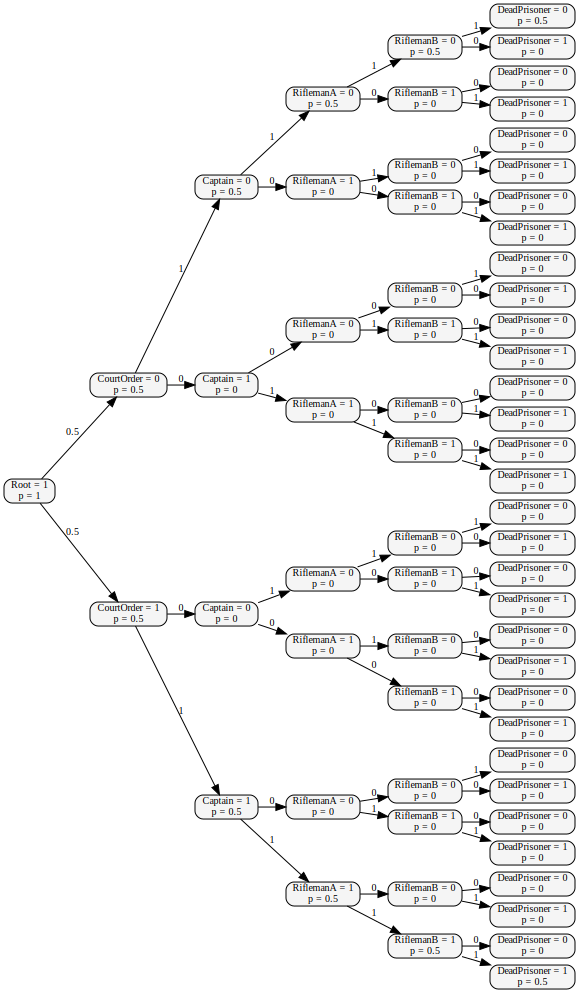

In [6]:
fs = PTree.fromFunc(A_first_firing_squad, 'Root = 1')
# fs = PTree.fromFunc(B_first_firing_squad, 'Root = 1')
# fs = PTree.fromFunc(misspecified_firing_squad, 'Root = 1')

display(fs.show(show_prob=True))


## S1: Prediction
 If rifleman A did not shoot, then the prisoner is alive.
 
 $$\lnot A\implies \lnot D$$
 
 

In [7]:
from IPython.display import Latex
cut_not_A = fs.prop('RiflemanA=0')
crit_not_A = fs.critical(cut_not_A)
fs_see_not_A = fs.see(cut_not_A)

# Compute probability distributions for earthquake and burglar.
display(Latex('$$P(\lnot D | \lnot A) = %f$$' % fs_see_not_A.prob(fs.prop('DeadPrisoner=0'))))



<IPython.core.display.Latex object>

## S2 Abduction
If the prisoner is alive, then the captain did not signal.

$$\lnot D \implies \lnot C$$

In [8]:

fs_see_not_D = fs.see(fs.prop('DeadPrisoner=0'))

# Compute probability distributions for earthquake and burglar.
display(Latex('$$P(\lnot C | \lnot D) = %f$$' % fs_see_not_D.prob(fs.prop('Captain=0'))))
# Display the conditional probability tree.



<IPython.core.display.Latex object>

## S3 Transduction

If rifleman A shot, then B shot as well

$$A\implies B$$

In [9]:

fs_see_A = fs.see(fs.prop('RiflemanA=1'))

# Compute probability distributions for earthquake and burglar.
display(Latex('$$P(B | A) = %f$$' % fs_see_A.prob(fs.prop('RiflemanB=1'))))
# Display the conditional probability tree.


<IPython.core.display.Latex object>

## S4 Action
If the captain gave no signal and rifleman A decides to shoot, then the prisoner will die and B will not shoot.

$$\lnot C\implies D_A \wedge \lnot B_{A}$$

In [10]:
not_C = fs.prop('Captain=0')
A = fs.prop('RiflemanA=1')
s4_see_not_C_do_A = fs.see(not_C).do(A)
display(Latex('$$P(D_{A}, \lnot B_{A}| \lnot C ) = %f$$' %
      s4_see_not_C_do_A.prob(fs.prop('DeadPrisoner=1') & fs.prop('RiflemanB=0'))))

<IPython.core.display.Latex object>

## S5 Counterfactual

If the prisoner is dead, then the prisoner would be dead even if rifleman A had not shot

$$D\implies D_{\lnot A}$$

In [11]:
D = fs.prop('DeadPrisoner=1')
indicative_premise = fs.see(D)
subjunctive_cut = fs.prop("RiflemanA=0")
s5_counterfactual = fs.cf(indicative_premise, subjunctive_cut)
display(Latex('$$P(D_{\lnot A} | D ) = %f$$' % 
      s5_counterfactual.prob(fs.prop('DeadPrisoner=1') )))



<IPython.core.display.Latex object>

# Nervous Firing squad 

Assumptions:
1.   there is a probability $P(U) = p$ that the court has ordered the execution;
2.   rifleman A has a probability $q$ of pulling the trigger out of nervousness; and
3.   rifleman A’s nervousness is independent of $U$.

## Nervous firing squad

In [12]:
def nervous_firing_squad(bvar):
    # Define the Court order and Nervous Rifleman A events.
    #new_bvars = None
    if 'CourtOrder' not in bvar and 'Nervous' not in bvar:
        p = 0.5   # Probability of Court Order
        q = 0.1
        return [((1-p)*(1-q),'CourtOrder=0,Nervous=0'), 
                (    p*(1-q),'CourtOrder=1,Nervous=0'),
               ( (1-p)*q,    'CourtOrder=0,Nervous=1'),
               (     p*q,    'CourtOrder=1,Nervous=1')]
    
    elif 'Captain' not in bvar:
        if bvar['CourtOrder'] == '0':
            return [(1,'Captain=0'),
                    (0,'Captain=1')]
        else:
            return [(0,'Captain=0'),
                    (1,'Captain=1')]
    elif 'RiflemanA' not in bvar:
        if bvar['Captain'] == '0' and bvar['Nervous'] == '0':
            return [(1,'RiflemanA=0'),
                    (0,'RiflemanA=1'),
                    ]
        else:
            return [(0,'RiflemanA=0'),
                    (1,'RiflemanA=1'),
                    ]
    elif 'RiflemanB' not in bvar:
        if bvar['Captain'] == '0':
            return [(1,'RiflemanB=0'),
                    (0,'RiflemanB=1'),
                    ]
        else:
            return [(0,'RiflemanB=0'),
                    (1,'RiflemanB=1'),
                    ]
    elif 'DeadPrisoner' not in bvar:
        if bvar['RiflemanA']  == '0' and bvar['RiflemanB'] == '0':
            return [(1,'DeadPrisoner=0'),
                    (0,'DeadPrisoner=1')]
        else:
            return [(0,'DeadPrisoner=0'),
                    (1,'DeadPrisoner=1')]

    else:
        return None


## Probability tree


Nervous Firing Squad probability tree:


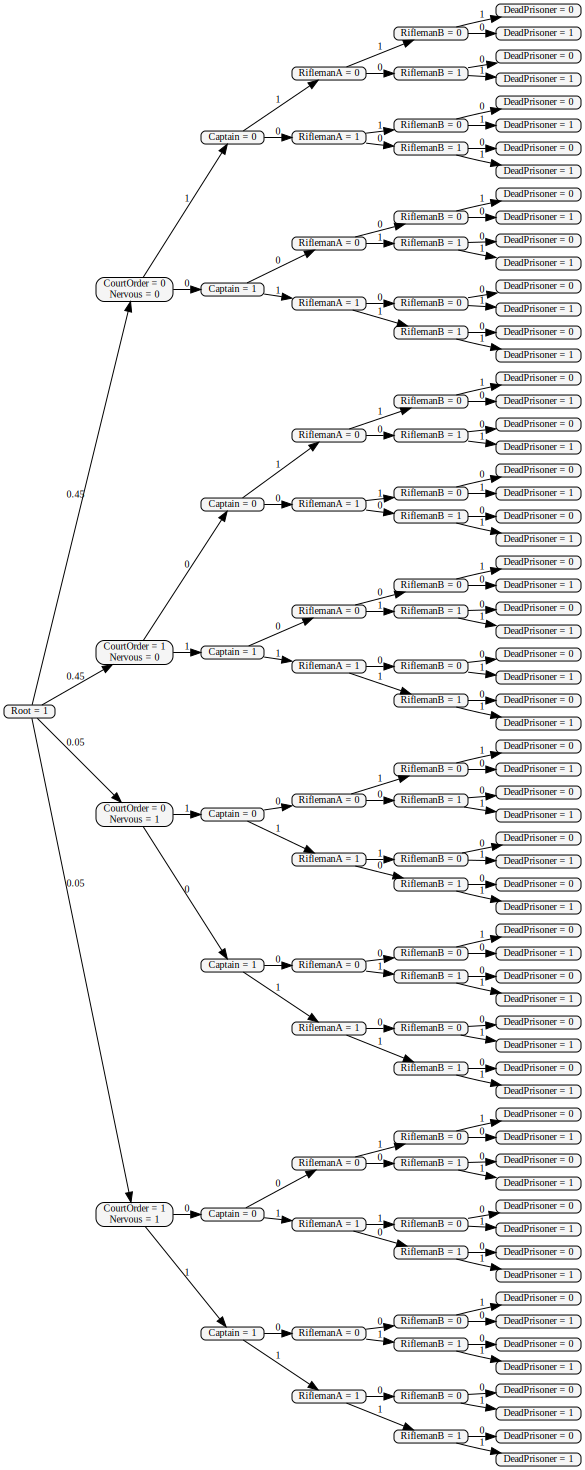


Some samples from the probability tree:
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}
{'Root': '1', 'CourtOrder': '0', 'Nervous': '0', 'Captain': '0', 'RiflemanA': '0', 'RiflemanB': '0', 'DeadPrisoner': '0'}


In [13]:
nfs = PTree.fromFunc(nervous_firing_squad, 'Root = 1')

print('\nNervous Firing Squad probability tree:')
display(nfs.show())

print('\nSome samples from the probability tree:')
for k in range(5):
  print(nfs.sample())

##  S6 Probabilistic counterfactual

With these assumptions, we wish to compute the quantity $P(\lnot D_{\lnot A}|D)$ namely, the probability that the prisoner would be alive if A had not shot, given that the prisoner is in fact dead.

Intuitively, we can figure out the answer by noting that $\lnot D_{\lnot A}$  is true if and only if the court has not issued an order. Thus, our task amounts to that of computing , which evaluates to $\frac{q(1 - p)}{[1 - (1 - q)(1 - p)]}$. However, our aim is to demonstrate a general and formal method of deriving such probabilities, based on (7.4), that makes little use of intuition.


Pearl, Judea. Causality (p. 212). Cambridge University Press. Kindle Edition. 

In [14]:

p,q = 0.5, 0.1
D_star = (q*(1-p))/(1- (1-q)*(1-p))
D_star

0.09090909090909091

If  $p=0.5$ and $q=0.1$, then $$P(\lnot D_{\lnot A}|D) = \frac{q(1 - p)}{[1 - (1 - q)(1 - p)]}  = 0.090909...$$

In [15]:
D = nfs.prop('DeadPrisoner=1')
indicative_premise = nfs.see(D)
subjunctive_cut = nfs.prop("RiflemanA=0")
s6_counterfactual = nfs.cf(indicative_premise, subjunctive_cut)


display(Latex('$P(\lnot D_{\lnot A} | D ) = %f$' % 
      s6_counterfactual.prob(nfs.prop('DeadPrisoner=0') )))


<IPython.core.display.Latex object>